# Miniproject 2
Github repo for this project: https://github.com/Ton201/ML_Miniproject2

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# model selection 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Evaluation
from sklearn.metrics import accuracy_score


## Data processing
To be able to clasifiy texts, I aim to use the bag of words representaion. This require to construct a corpus on trainning dataset. The first step is splitting the dataset into training/testing subset (ratio 50/50).

### Splitting

In [2]:
data = pd.read_csv('../raw_data/IMDB_Dataset.csv')

In [3]:
display(data.head())
print(data.shape)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


(50000, 2)


In [4]:
rd_seed = 42

Xtrain, Xtest, ytrain, ytest = train_test_split(data["review"], data["sentiment"], test_size=0.5, random_state=rd_seed)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.15, random_state=rd_seed)

In [5]:
data_test = pd.concat([Xtest, ytest], axis=1)
data_test

,review,sentiment
33553,I really liked this Summerslam due to the look...,positive
9427,Not many television shows appeal to quite as m...,positive
199,The film quickly gets to a major chase scene w...,negative
12447,Jane Austen would definitely approve of this o...,positive
39489,Expectations were somewhat high for me when I ...,negative
...,...,...
7110,More directors like Nacho Vigalondo need a gre...,positive
46643,Rita Hayworth lights up the screen in this fun...,positive
5440,"The biggest heroes, is one of the greatest mov...",positive
33017,I happened to see a promo for this movie on Sp...,negative


In [6]:
data_test.to_csv('../processed_data/test_set.csv')

In [7]:
Xtrain.shape

(21250,)

## Bag of words representation

In [8]:
vectorizer = TfidfVectorizer()
XtrainVector = vectorizer.fit_transform(tqdm(Xtrain))
XvalVector = vectorizer.transform(tqdm(Xval))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:00<00:00, 5348.44it/s]


## Model selection

### Naive Bayes
The first model I am going to try will be Naive Bayes clasifier, since it is a simple model a this task is its model use case. It is necessary to use MultinomialNB althougth GaussianNB would make more sence. GausianNB is not optimized for sparse data and converting large sparse data to array consumes requires too much memory.

In [9]:
nb_clf= MultinomialNB()
nb_clf.fit(XtrainVector, ytrain)
print('Classes of y:', nb_clf.classes_)
print('Claases distribution:',nb_clf.class_count_) # training dataset seems to be balanced
print(f"Training acc: {nb_clf.score(XtrainVector, ytrain):.4f}")
print(f"Validatoin acc: {nb_clf.score(XvalVector, yval):.4f}")
best_nb_acc = nb_clf.score(XvalVector, yval)

Classes of y: ['negative' 'positive']
Claases distribution: [10671. 10579.]
Training acc: 0.9140
Validatoin acc: 0.8509


### Logistic regression

Second model I am going to try is logistic regression because it is quite powerful clasification model. It is a bit more complex than naive bayes clasifier and requires more tuning. In the first step I am going to try several regularisations to see which produces best performing model. 

In [10]:
lr_clf = LogisticRegression(random_state=rd_seed)
lr_clf.fit(XtrainVector,ytrain)
print(f"Trainning acc: {lr_clf.score(XtrainVector, ytrain):.4f}")
print(f"Validation acc: {lr_clf.score(XvalVector, yval):.4f}")

Trainning acc: 0.9316
Validation acc: 0.8819


In [11]:
lr_clf = LogisticRegression(solver='saga',penalty='l1',random_state=rd_seed) # SAGA - stochstic gradient descent
lr_clf.fit(XtrainVector,ytrain)
print(f"Trainning acc: {lr_clf.score(XtrainVector, ytrain):.4f}")
print(f"Validation acc: {lr_clf.score(XvalVector, yval):.4f}")

Trainning acc: 0.8939
Validation acc: 0.8653


In [12]:
lr_clf = LogisticRegression(solver='saga', penalty='elasticnet',l1_ratio=0.2,random_state=rd_seed)
lr_clf.fit(XtrainVector,ytrain)
print(f"Trainning acc: {lr_clf.score(XtrainVector, ytrain):.4f}")
print(f"Validation acc: {lr_clf.score(XvalVector, yval):.4f}")

Trainning acc: 0.9142
Validation acc: 0.8803


L1 metric does perform worse even the combination of L1 and L2 metric does not outperform L2 regularisation. In addition to that L2 regularised Logistic reqresion with default 'lbfgs' sover was by far the fastest learning model. Therefore only the default solver and regualristion (penalty) will be taken into consideration for further tuning.
#### Regularisation weight tuning

In [13]:
def train_logistic_c(begin, end, zoom=10, mode='visual'):
    Cs = np.linspace(begin, end, zoom)
    ACC = {}
    for i, c in enumerate(tqdm(Cs)):
        clf = LogisticRegression(C=c,random_state=rd_seed)
        clf.fit(XtrainVector, ytrain)
        acc_train = clf.score(XtrainVector, ytrain)
        acc_val = clf.score(XvalVector, yval)
        ACC[c] = [acc_train, acc_val]
    if mode =='visual':
            # accs_train = [i[0] for i in ACC.values()]
            accs_val = [i[1] for i in ACC.values()]
            # plt.plot(Cs, accs_train, '.', label='train')
            plt.plot(Cs, accs_val, '.', label='validation')
            plt.title('Logistic regression validation accuracy as function of regularisation weight C')
            plt.xlabel("C")
            plt.ylabel("ACC")
            # plt.legend(loc='center right')
            plt.show()
    elif mode == 'png':
            plt.plot(Cs, ACC.values()[0], '.')
            plt.title('Logistic regression validation accuracy as function of regularisation weight C')
            plt.xlabel("C")
            plt.ylabel("ACC")
            plt.savefig('../images/lr_training.png')
    return Cs, ACC

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.47s/it]


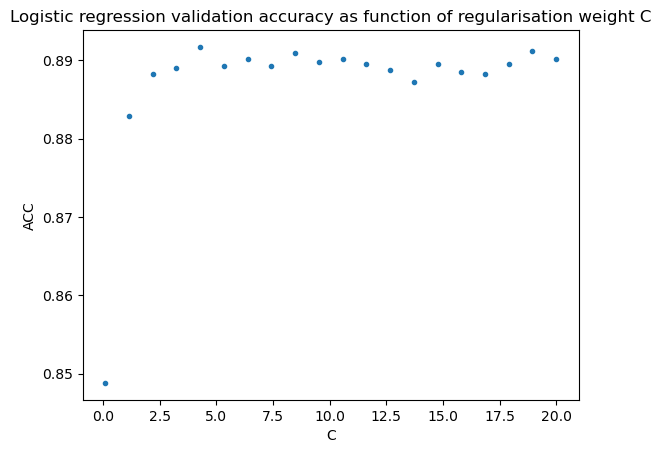

In [14]:
cs, acc = train_logistic_c(0.1,20,zoom=20)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.86s/it]


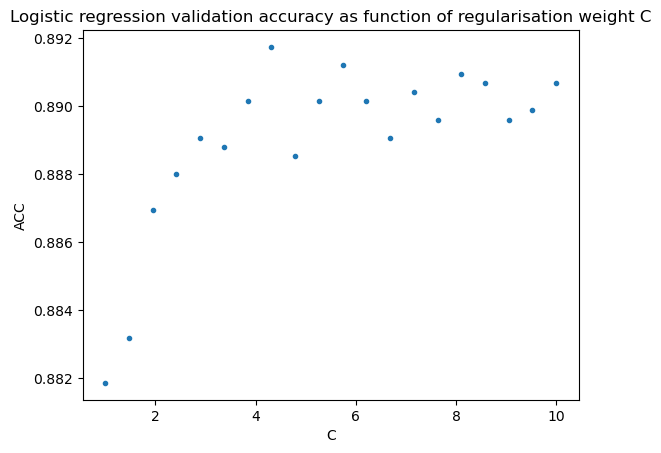

In [15]:
cs, acc = train_logistic_c(1,10,zoom=20)

In [16]:
val_accs = [i[1] for i in acc.values()]
np.max(val_accs)

0.8917333333333334

In [17]:
pprint(acc)

{1.0: [0.9315764705882353, 0.8818666666666667],
 1.4736842105263157: [0.9424, 0.8832],
 1.9473684210526314: [0.9507294117647059, 0.8869333333333334],
 2.4210526315789473: [0.9567529411764706, 0.888],
 2.894736842105263: [0.9622117647058823, 0.8890666666666667],
 3.3684210526315788: [0.9659294117647059, 0.8888],
 3.8421052631578947: [0.9696470588235294, 0.8901333333333333],
 4.315789473684211: [0.9721411764705883, 0.8917333333333334],
 4.789473684210526: [0.9727058823529412, 0.8885333333333333],
 5.263157894736842: [0.9760941176470588, 0.8901333333333333],
 5.7368421052631575: [0.9782117647058823, 0.8912],
 6.2105263157894735: [0.9790117647058824, 0.8901333333333333],
 6.684210526315789: [0.9808, 0.8890666666666667],
 7.157894736842105: [0.982964705882353, 0.8904],
 7.63157894736842: [0.9816470588235294, 0.8896],
 8.105263157894736: [0.9817882352941176, 0.8909333333333334],
 8.578947368421051: [0.9847529411764706, 0.8906666666666667],
 9.052631578947368: [0.9862588235294117, 0.8896],
 9

Best  value of hyperparameter **C is approximately 4.316**.

In [18]:
lr_clf = LogisticRegression(C=4.316,random_state=rd_seed)
lr_clf.fit(XtrainVector,ytrain)
print(f"Trainning acc: {lr_clf.score(XtrainVector, ytrain):.4f}")
print(f"Validation acc: {lr_clf.score(XvalVector, yval):.4f}")

Trainning acc: 0.9721
Validation acc: 0.8917


### NN

In [20]:
XtrainVector.shape

(21250, 71354)

In [32]:
from keras import layers
from keras import callbacks
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

nn = keras.models.Sequential()
nn.add(keras.layers.Dense(units=1000, activation='leaky_relu', input_shape=(71354,) ))
nn.add(keras.layers.Dense(units=100, activation='leaky_relu'))
nn.add(keras.layers.Dropout(0.2)) 
nn.add(keras.layers.Dense(units=10, activation='leaky_relu'))
nn.add(keras.layers.Dense(units=1, activation='sigmoid'))

nn.compile(
    optimizer = Adam(learning_rate=1e-3),
    loss = BinaryCrossentropy(),
    metrics = ["accuracy"],
    )

callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=4),
    callbacks.ModelCheckpoint(filepath='nn_training/best_model_param.keras', monitor='val_loss', save_best_only=True)
]


/home/tonik/miniconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# Dictionary mapping for replacement
replacement_dict = {'negative': 0, 'positive': 1}

# Using map()
ytrain_mapped = ytrain.map(replacement_dict)
yval_mapped = yval.map(replacement_dict)


In [42]:
history = nn.fit(
    XtrainVector, ytrain_mapped,
    epochs = 10,
    verbose = 1,
    batch_size=100,
    validation_data=(XvalVector, yval_mapped)
)

Epoch 1/10
  4/213 ━━━━━━━━━━━━━━━━━━━━ 2:43 782ms/step - accuracy: 0.8933 - loss: 0.2409

KeyboardInterrupt: 